In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa

In [2]:
CAPUCHIN_FILE = 'data/Parsed_Capuchinbird_Clips/XC114131-0.wav'
NOT_CAPUCHIN_FILE = 'data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav'

In [3]:
file_contents = tf.io.read_file(CAPUCHIN_FILE)
wav, sample_rate = librosa.load(CAPUCHIN_FILE, sr=None)
sample_rate

48000

In [4]:
wav.shape

(120000,)

In [5]:
wav = librosa.resample(wav, orig_sr=sample_rate, target_sr=16000)
len(wav)

40000

In [6]:
def load_wav_16k_mono(filename):
    # Convert TensorFlow tensor to string (file path)
    filepath = tf.constant(filename)
    filepath = filepath.numpy().decode('utf-8')

    # Load wav file
    wav, sample_rate = librosa.load(filepath, sr=None)

    # Resample the audio to the desired sample rate (e.g., 16000 Hz)
    wav = librosa.resample(wav, orig_sr=sample_rate, target_sr=16000)
    
    return wav

In [7]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

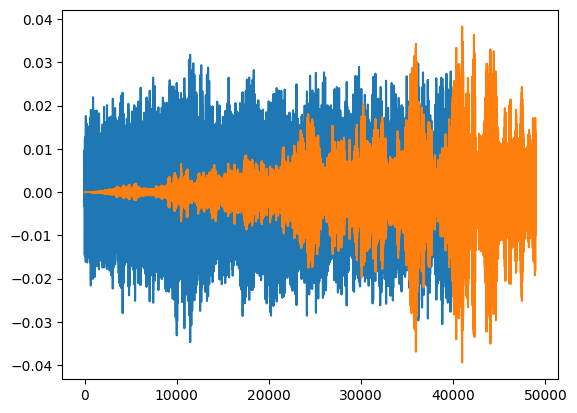


The Blue WaveForm is the Capuchin Audio and the Orange is the Non-Capuchin Audio
By using this as the chosen decoder we can build a CNN vision model to look at the WaveForms to make predictions


In [8]:
plt.plot(wave)
plt.plot(nwave)
plt.show()
print('\nThe Blue WaveForm is the Capuchin Audio and the Orange is the Non-Capuchin Audio')
print('By using this as the chosen decoder we can build a CNN vision model to look at the WaveForms to make predictions')

In [9]:
POS = 'data/Parsed_Capuchinbird_Clips'
NEG = 'data/Parsed_Not_Capuchinbird_Clips'

In [10]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [11]:
pos.as_numpy_iterator().next()

b'data/Parsed_Capuchinbird_Clips/XC456236-2.wav'

In [12]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [13]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [14]:
data.as_numpy_iterator().next()

(b'data/Parsed_Capuchinbird_Clips/XC44070-0.wav', 1.0)

In [16]:
lengths = []
for file in os.listdir(POS):
  tensor_wave = load_wav_16k_mono(POS + '/' + file)
  lengths.append(len(tensor_wave))

lengths[0:10]

[32000, 40000, 64000, 48000, 56000, 56000, 72000, 80000, 64000, 64000]

In [17]:
print(f'Mean Length: {tf.math.reduce_mean(lengths).numpy()}\nMin Length: {tf.math.reduce_min(lengths).numpy()}\nMax Length: {tf.math.reduce_max(lengths).numpy()}')

Mean Length: 54156
Min Length: 32000
Max Length: 80000


In [18]:
print(f'At 16000Hz this means our average Capuchin Clip is about {54156/16000} seconds long')

At 16000Hz this means our average Capuchin Clip is about 3.38475 seconds long


In [19]:
def preprocess(file_path, label):
    # Define a helper function to process each file path
    def _process_file(file_path):
        # Convert the tensor to a string
        file_path_str = file_path.numpy().decode('utf-8')

        # Load wav file
        wav = load_wav_16k_mono(file_path_str)

        # Pad the waveform if necessary
        wav = wav[:48000]  # Grab the first 3 seconds of each clip
        zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)  # Pad shorter clips with zeros
        wav = tf.concat([zero_padding, wav], 0)

        # Compute the spectrogram
        spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
        spectrogram = tf.abs(spectrogram)
        spectrogram = tf.expand_dims(spectrogram, axis=2)

        return spectrogram

    # Apply the processing function to each file path
    processed_data = tf.py_function(_process_file, [file_path], tf.float32)
    processed_data.set_shape((1491, 257, 1))  # Set the shape of the spectrogram tensor
    return processed_data, label


In [20]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [21]:
spectrogram, label = preprocess(filepath, label)

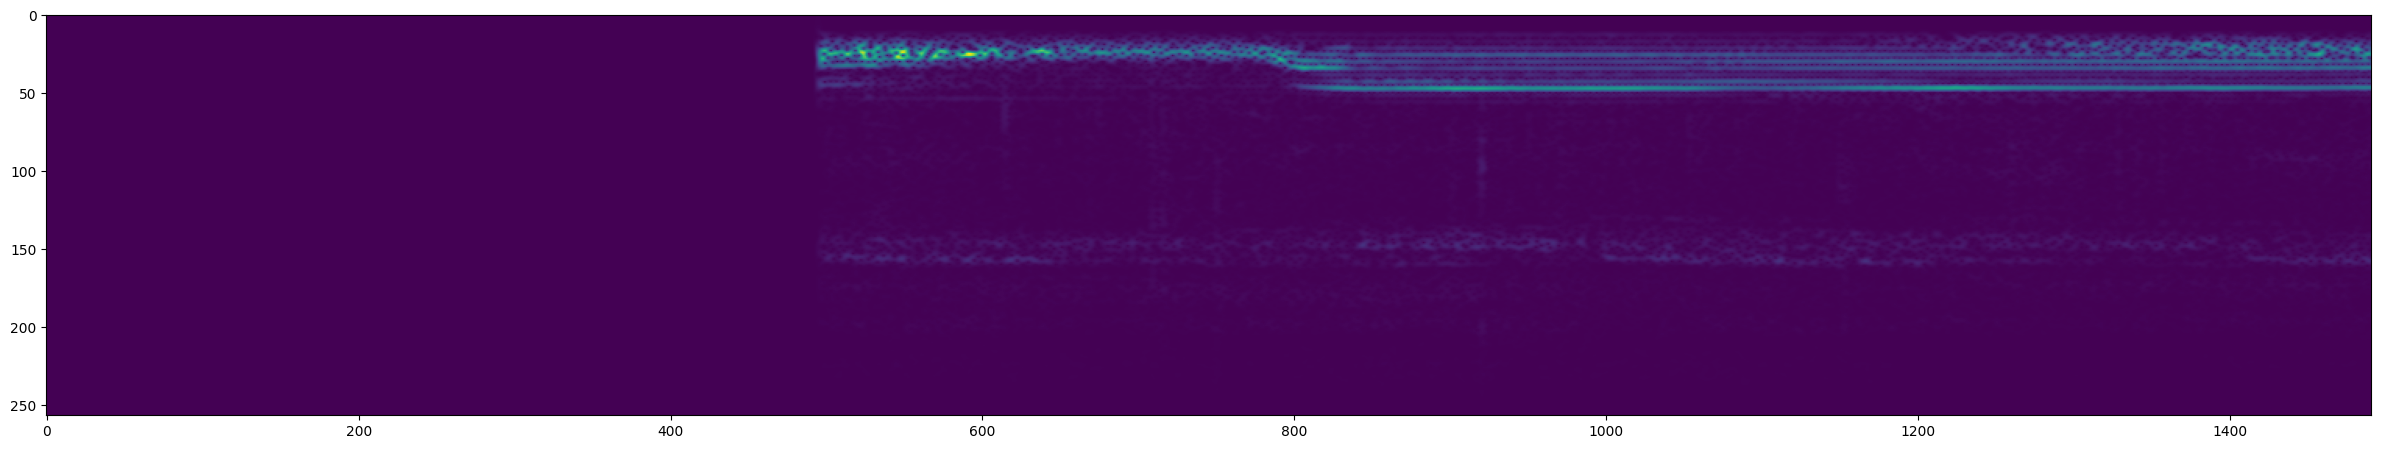

In [22]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])

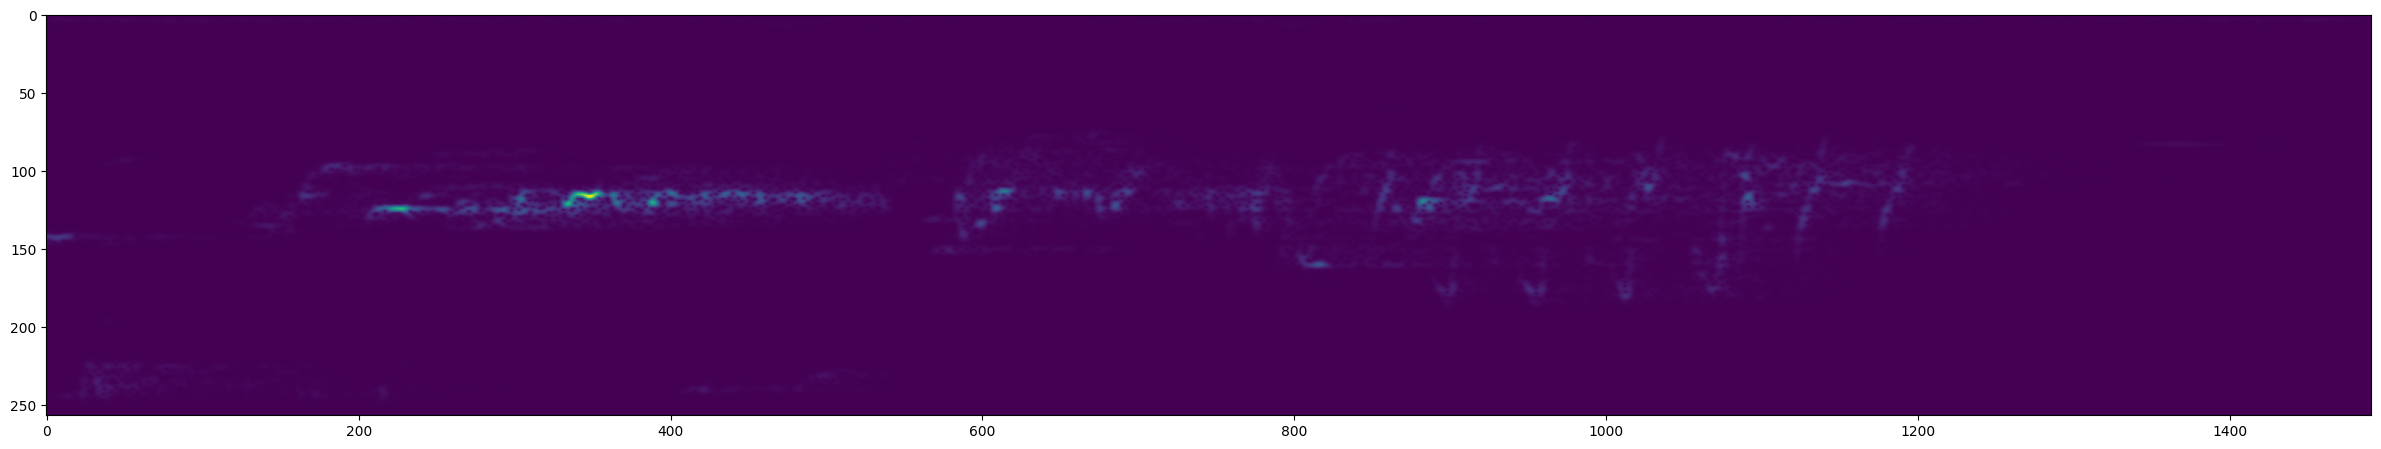

In [23]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])

In [24]:
data = data.map(preprocess)
print(data)
data = data.cache()
data = data.shuffle(1000)
data = data.batch(16)
data = data.prefetch(8)

<_MapDataset element_spec=(TensorSpec(shape=(1491, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [26]:
train_size = round(len(data) * .7) #Find what 70% of the data is for splitting

In [27]:
train = data.take(train_size)
test = data.skip(train_size).take(len(data)-train_size)
len(train), len(test), len(data)

(36, 15, 51)

In [29]:
samples, labels = train.as_numpy_iterator().next()

In [30]:
samples.shape, labels.shape

((16, 1491, 257, 1), (16,))

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [32]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(1491,257,1)),
    Conv2D(16, (3,3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1489, 255, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1487, 253, 16)  │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6019376)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   770,480,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770,482,865 (2.87 GB)

 Trainable params: 770,482,865 (2.87 GB)

 Non-trainable params: 0 (0.00 B)

In [33]:
hist = model.fit(train, epochs=5, validation_data=test)

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1150s 32s/step - loss: 4.4187 - precision: 0.7685 - recall: 0.8603 - val_loss: 0.4317 - val_precision: 0.9275 - val_recall: 1.0000
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1100s 30s/step - loss: 0.0890 - precision: 0.9685 - recall: 0.9834 - val_loss: 0.2615 - val_precision: 0.9677 - val_recall: 1.0000
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1107s 31s/step - loss: 0.0789 - precision: 0.9710 - recall: 0.9914 - val_loss: 0.0018 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1195s 33s/step - loss: 0.0872 - precision: 0.9916 - recall: 0.9948 - val_loss: 0.0019 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1104s 31s/step - loss: 0.0025 - precision: 1.0000 - recall: 1.0000 - val_loss: 9.1011e-04 - val_precision: 1.0000 - val_recall: 1.0000


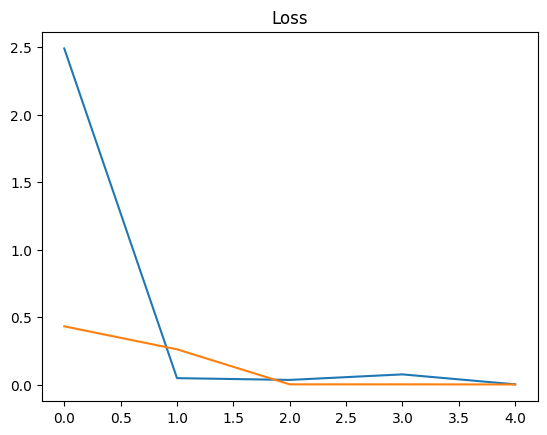

In [34]:
plt.title('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

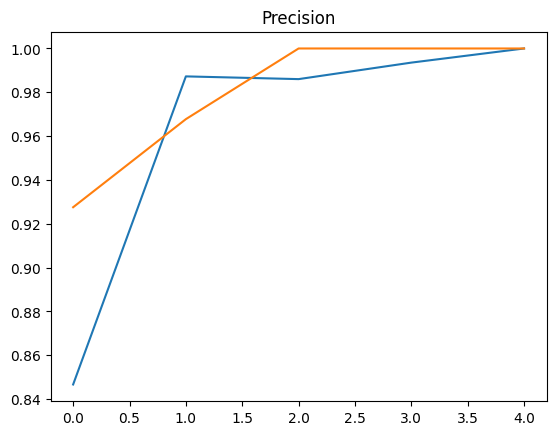

In [36]:
plt.title('Precision')
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.show()

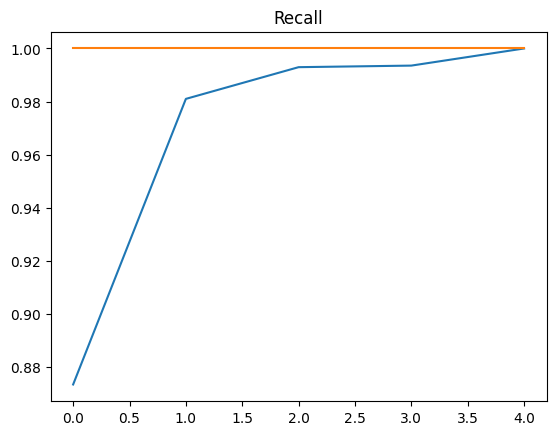

In [37]:
plt.title('Recall')
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.show()

## Make a Prediction

In [38]:
X_test, y_test = test.as_numpy_iterator().next()

In [39]:
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


In [42]:
y_pred = [1 if prediction > 0.5 else 0 for prediction in y_pred]
y_test.astype('int')[:10],y_pred[:10]

(array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0]), [0, 0, 1, 0, 0, 0, 0, 0, 1, 0])

## Finding Capuchin's in the Forest audio

In [ ]:
def load_wav_16k_mono(filename):
    # Convert TensorFlow tensor to string (file path)
    filepath = tf.constant(filename)
    filepath = filepath.numpy().decode('utf-8')

    # Load wav file
    wav, sample_rate = librosa.load(filepath, sr=None)

    # Resample the audio to the desired sample rate (e.g., 16000 Hz)
    wav = librosa.resample(wav, orig_sr=sample_rate, target_sr=16000)
    
    return wav

In [43]:
import pydub
from pydub import AudioSegment
import io

def load_mp3_16k_mono(filename):
    # Read the MP3 file
    audio = AudioSegment.from_mp3(filename)

    # Convert stereo to mono
    audio = audio.set_channels(1)

    # Export as WAV format to an in-memory file-like object
    wav_io = io.BytesIO()
    audio.export(wav_io, format="wav")

    # Read the WAV data from the in-memory object
    wav_io.seek(0)
    wav, sample_rate = librosa.load(wav_io, sr=None)

    # Resample the audio to the desired sample rate (e.g., 16000 Hz)
    wav = librosa.resample(wav, orig_sr=sample_rate, target_sr=16000)
    
    return wav

In [44]:
mp3 = 'data/Forest Recordings/recording_00.mp3'
wav = load_mp3_16k_mono(mp3)

python(24218) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24221) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [50]:
wav.shape, wav[:10]

((2880667,),
 array([-2.2643415e-05, -2.8719427e-05, -3.7775453e-06, -5.5195942e-06,
        -1.4096724e-05, -9.6451658e-06, -7.8159201e-06, -2.7517133e-05,
        -2.2557821e-05, -3.5421657e-05], dtype=float32))

In [98]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [105]:
samples, index = audio_slices.as_numpy_iterator().next()

In [106]:
preprocess_mp3(samples, index)

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[3.6692300e-03],
        [2.8475861e-03],
        [1.1937192e-03],
        ...,
        [3.9554007e-07],
        [3.6709242e-08],
        [1.6298145e-09]],

       [[3.6627410e-03],
        [2.8305664e-03],
        [1.1803972e-03],
        ...,
        [1.6510687e-07],
        [9.0503704e-08],
        [1.7904676e-07]],

       [[3.6392852e-03],
        [2.8106570e-03],
        [1.1734896e-03],
        ...,
        [2.1346767e-07],
        [1.0115956e-07],
        [5.5180863e-08]],

       ...,

       [[4.3458450e-01],
        [4.2058581e-01],
        [3.5347486e-01],
        ...,
        [7.1654265e-04],
        [4.8010689e-04],
        [4.8682094e-05]],

       [[3.3830065e-01],
        [3.2303286e-01],
        [3.0666697e-01],
        ...,
        [1.3042883e-03],
        [2.5423832e-04],
        [2.8073788e-04]],

       [[2.4638532e-01],
        [1.7000073e-01],
        [2.1400149e-01],
        ...,
        [1.3359960

#### For this clip specifically it split the sound into 60 different windows, our model will iterate over the windows and count the positive Capuchin classifications

In [53]:
len(audio_slices)

60

In [96]:
def preprocess_mp3(sample, label):
    sample = tf.convert_to_tensor(sample[0])
    # Define a helper function to process each file path
    # Convert the tensor to a string
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)  # Pad shorter clips with zeros
    wav = tf.concat([zero_padding, sample], 0)

        # Compute the spectrogram
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    spectrogram.set_shape((1491, 257, 1))

    return spectrogram

In [108]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [109]:
audio_slices

<_BatchDataset element_spec=TensorSpec(shape=(None, 1491, 257, 1), dtype=tf.float32, name=None)>

In [119]:
y_pred = model.predict(audio_slices)
y_pred = [1 if prediction > 0.9 else 0 for prediction in y_pred]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [120]:
y_pred

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

#### Consecutive detections are actually the same call over a long period of time, so we need to reduce consecutive classifications to 1 each

In [121]:
from itertools import groupby

In [122]:
yhat = [key for key, group in groupby(y_pred)]
calls = tf.math.reduce_sum(yhat).numpy()

In [124]:
yhat, calls

([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0], 5)

In [126]:
results = {}
for file in os.listdir('data/Forest Recordings/'):
    FILEPATH = os.path.join('data', 'Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    y_pred = model.predict(audio_slices)

    results[file] = y_pred

python(24763) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24765) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


python(24766) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24767) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step


python(24768) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24769) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step


python(24770) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24771) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step


python(24772) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24773) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


python(24774) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24775) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step


python(24776) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24777) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24780) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24781) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24783) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24784) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24785) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24786) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step


python(24787) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24788) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step


python(24789) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24791) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24792) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24793) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24794) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24796) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24797) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24800) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


python(24801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24802) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24804) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24805) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


python(24806) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24807) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


python(24808) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24809) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24810) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24811) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24812) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24813) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24814) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24815) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24816) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24817) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24818) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24819) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step


python(24820) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24821) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


python(24823) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24824) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24825) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24826) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24827) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24828) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


python(24829) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24830) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


python(24831) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24832) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


python(24833) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24835) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24836) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24837) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24838) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step


python(24839) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24840) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24841) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24842) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24843) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24844) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24845) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24846) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


python(24847) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24848) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24849) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24850) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24851) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24852) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


python(24853) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24854) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


python(24855) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24856) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step


python(24857) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24858) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24859) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24860) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24862) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24863) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24864) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24865) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


python(24866) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24867) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24868) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24869) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


python(24870) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24871) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24872) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24873) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24874) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24875) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24876) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24877) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


python(24878) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24879) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


python(24880) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24881) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


python(24882) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24883) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


python(24884) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24885) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


python(24886) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24887) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


python(24888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24889) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step


python(24890) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step


python(24892) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step


python(24894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24895) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step


python(24896) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24897) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


python(24898) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24899) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step


python(24900) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24901) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step


python(24903) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24904) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step


python(24905) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24906) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


python(24907) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24908) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step


python(24909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step


python(24911) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24912) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step


python(24913) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24914) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step


python(24915) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24916) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step


python(24917) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24918) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


python(24919) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24920) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step


python(24921) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step


python(24923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24924) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step


python(24925) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24926) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


python(24927) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24928) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step


python(24929) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24930) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step


python(24931) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24932) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step


python(24933) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24934) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step


python(24935) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24936) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


python(24937) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24938) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


python(24939) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24940) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step


python(24941) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24942) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step


python(24943) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24944) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


python(24946) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24947) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


python(24948) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24949) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step


python(24950) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24951) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step


python(24952) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24953) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step


python(24954) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24955) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


python(24956) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24957) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


python(24958) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24959) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


python(24960) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24961) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step


python(24962) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24963) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step


python(24964) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24965) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step


python(24966) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24967) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


python(24968) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24969) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step


python(24970) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24971) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


### Convert preds to classes

In [128]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.9 else 0 for prediction in logits]

In [131]:
class_preds['recording_01.mp3']

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

### Group the consecutive predictions

In [135]:
total_counts = {}
for file, scores in class_preds.items():
    total_counts[file] = tf.math.reduce_sum([key for key, group in groupby(scores)])
total_counts

{'recording_95.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 'recording_81.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=4>,
 'recording_56.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 'recording_42.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 'recording_43.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 'recording_57.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=4>,
 'recording_80.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 'recording_94.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 'recording_82.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 'recording_96.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 'recording_69.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 'recording_41.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 'recording_55.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 'recording_54.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 'recording_40.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 'recordin

In [141]:
total_counts['recording_00.mp3'].numpy()

5

I'm getting 20 calls in recording #8, which is the most of all the files

In [145]:
import csv

# Open the CSV file for writing
with open('capuchin_bird_results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    
    # Write the header row
    writer.writerow(['recording', 'capuchin_calls'])
    
    # Iterate over each item in total_counts
    for key, value in total_counts.items():
        # Extract the numpy value if value is a tensor
        if isinstance(value, tf.Tensor):
            value = value.numpy()
        
        # Write the row to the CSV file
        writer.writerow([key, value])


### Lets verify!

In [147]:
import pandas as pd
df = pd.read_csv('capuchin_bird_results.csv')
df.head()

,recording,capuchin_calls
0,recording_95.mp3,5
1,recording_81.mp3,4
2,recording_56.mp3,2
3,recording_42.mp3,0
4,recording_43.mp3,5


In [153]:
df = df.sort_values(by='capuchin_calls', axis=0, ascending=False)
df.head()

,recording,capuchin_calls
41,recording_08.mp3,20
99,recording_98.mp3,16
18,recording_87.mp3,16
45,recording_23.mp3,7
64,recording_16.mp3,7
